In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
np.random.seed(2017)
from scipy.fft import fft, ifft
from Scripts.modelRepr import RingModel, Input, perturbedRingModel, model_from_image
from Scripts.ISTrans import series_signal2img
from Scripts.ISTransConfig import *
from Scripts.Tools.vectorTrans import trans_kernel, itrans_kernel
import matplotlib.pyplot as plt

plt.rcParams['legend.fontsize'] = 14  # Set global font size for the title


ModuleNotFoundError: No module named 'brian2'

# Model and Method

In [ ]:
class Dummy:
    pass

def naka(C, fmax, C_50, p=3.5):
    return fmax*C**p/(C_50**p + C**p)

def naka_inv(contrasts, fmax, C_50, p=3.5):
    return (C_50**p/fmax/(1/contrasts - 1/fmax))**(1/p)

def single_gaussian(theta, center, size_ext, periodic=True):
    if periodic: 
        return np.exp(-(theta - center)**2/(2*size_ext**2))+np.exp(-(theta - center+180)**2/(2*size_ext**2))+np.exp(-(theta - center-180)**2/(2*size_ext**2))
    else:
        return np.exp(-(theta - center)**2/(2*size_ext**2))
    
def sin_input(theta,fre,amp):
    return np.sin(2*np.pi*theta/180*fre)*amp

def cos_input(theta,fre,amp):
    return np.cos(2*np.pi*theta/180*fre)*amp

def average_firing_rate(step, dtime: second, spike_mon: SpikeMonitor):
    time_range = np.linspace(0, step*dtime/second, step+1, endpoint=True).reshape(-1, 1)*second
    train = spike_mon.spike_trains()
    avg_rate = np.array([np.sum(((time_range[:step] <= train[i])&(time_range[1:] > train[i])).astype(int), axis=1)/dtime for i in range(len(train))])
    return avg_rate.T

def average_current(step, dtime, state: StateMonitor, name: str):
    time_range = np.linspace(0, step*dtime/second, step+1, endpoint=True).reshape(-1, 1)*second
    I = eval(f'state.{name}/pA')
    avg_current = np.array([np.average(I[:, (time_range[i] <= state.t)&(time_range[i+1] > state.t)], axis=1) for i in range(step)])
    return avg_current

def default_params():
    params = Dummy()
    init_network(params, 
    C=10,
    dtime=10*second,
    C_bg=0,
    N = 120,
    W = 1.028,
    N_input=1,
    center=45 ,
    size_ext=25,
    D=0, 
    sparsity=1, failure_rate=.5,
    sparsityEE=1,sparsityEI=1,sparsityIE=1,sparsityII=1,
    fmax=100.1,C_50=20,
    #Fixed Parameters
        tau_m=15*ms, tau_E=3*ms, tau_I=3*ms, tau_ref=0*ms,
        g_EI=1.42*nS, g_II=1.2*nS, g_EE=1.8*nS, g_IE= 2.06*nS, g_L=10*nS,
        R_L=-70*mV,  R_E=0*mV, R_I=-80*mV, V_th=-50*mV, V_r=-56*mV,
        A=0, B=1, sigma_ori=25,fre=0,amp=0,Cs=30,
    #Fixed Parameters
    E_eqs_neurons ="""
    dv/dt = (-(v - R_L) + (R_E - v)*g_E/g_L +  (R_I - v)*g_I/g_L + (R_E - v)*g_in/g_L)/tau_m : volt (unless refractory)
    dg_E/dt = -g_E/tau_E : siemens
    dg_I/dt = -g_I/tau_I : siemens
    dg_in/dt = -g_in/tau_E: siemens
    I_exc = g_E*(R_E - v): ampere
    I_inh = abs(g_I*(R_I - v)): ampere
    I_ext = g_in*(R_E - v): ampere
    I_net = g_I*(R_I - v) + g_in*(R_E - v) + g_E*(R_E - v) : ampere
    theta : 1
    """,
    I_eqs_neurons ="""
    dv/dt = (-(v - R_L) + (R_E - v)*g_E/g_L +  (R_I - v)*g_I/g_L + (R_E - v)*g_in/g_L)/tau_m : volt (unless refractory)
    dg_E/dt = -g_E/tau_E : siemens
    dg_I/dt = -g_I/tau_I : siemens
    dg_in/dt = -g_in/tau_E: siemens
    I_exc = g_E*(R_E - v): ampere
    I_inh = abs(g_I*(R_I - v)): ampere
    I_ext = g_in*(R_E - v): ampere
    I_net = g_I*(R_I - v) + g_in*(R_E - v) + g_E*(R_E - v) : ampere
    theta : 1
    """,
    w_eqs = "w = int(abs(theta_pre-theta_post)<=90)*(A + B*exp(-(abs(theta_pre-theta_post)/(sqrt(2)*sigma_ori))**2)) + int(abs(theta_pre-theta_post)>90)*(A + B*exp(-((180-abs(theta_pre-theta_post))/(sqrt(2)*sigma_ori))**2)): 1 "
    )
    return params


def init_network(params, input_shape="single_gaussian", time_dependency=None, cpp_standalone = True, **kwargs):
    start_scope()
    # use cpp standalone
    if cpp_standalone:
        device.reinit()
        device.activate()
        pid = os.getpid()
        directory = f"standalone{pid}"
        set_device('cpp_standalone', directory=directory)

    for key, value in kwargs.items():
        params.__dict__.update({key: value})
    
    params.sparsityEE = params.sparsityEE
    params.sparsityIE = params.sparsityIE
    params.sparsityEI = params.sparsityEI
    params.sparsityII = params.sparsityII
    params.theta = np.arange(0, params.N)/params.N*180


    # params.g_ext = ((np.ones(params.N)*10/params.N_input + cos_input(np.arange(0,params.N)/params.N*180,params.fre,params.amp))/params.N_input).reshape((-1, params.N))*nS
    params.g_ext = TimedArray(((np.ones(params.N)*10 + cos_input(np.arange(0,params.N)/params.N*180,params.fre,params.amp))/params.N_input).reshape((-1, params.N))*nS, dt=params.dtime)
    # params.g_ext = TimedArray(ones(params.N)*10/params.N_input*nS + params.amp*cos(2*params.fre*params.theta)/params.N_input*nS, dt=params.dtime)
    params.g_ext_I = 10/params.N_input*nS
    params.r_ext = TimedArray(params.Cs*np.ones((1,params.N)).reshape((-1, params.N))*Hz, dt=params.dtime)
    # print(params.g_ext(1*second,1))
    
    # params.neurons = NeuronGroup(2*params.N, model=params.eqs_neurons, threshold='v>V_th', reset='v=V_r', refractory=params.tau_ref, method='euler', name="neurons")
    params.E_neurons = NeuronGroup(params.N, model=params.E_eqs_neurons, threshold='v>V_th', reset='v=V_r', refractory=params.tau_ref, method='euler', name="E_neurons")
    params.I_neurons = NeuronGroup(params.N, model=params.I_eqs_neurons, threshold='v>V_th', reset='v=V_r', refractory=params.tau_ref, method='euler', name="I_neurons")
    params.g_input_E = PoissonGroup(params.N, rates="N_input*r_ext(t, i)", name="poisson_E")    # Poission Input External Neurons
    params.g_input_I = PoissonGroup(params.N, rates="N_input*r_ext(t, i)", name="poisson_I")    # Poission Input External Neurons
    params.input_to_G_E = Synapses(params.g_input_E, params.E_neurons, on_pre='g_in += g_ext(t,i)', name="input_to_G_E") # Setting firing condition,
    params.input_to_G_I = Synapses(params.g_input_I, params.I_neurons, on_pre='g_in += g_ext_I', name="input_to_G_I") # Setting firing condition,
    params.g_background = PoissonGroup(params.N, rates="N_input*C_bg*Hz", name='background')
    params.background_to_G = Synapses(params.g_background, params.E_neurons, on_pre='g_in += g_ext', name="background_to_G") # Setting firing condition,
    # params.background_to_G = Synapses(params.g_background, params.I_neurons, on_pre='g_in += g_ext', name="background_to_G") # Setting firing condition,
    params.E_to_E = Synapses(params.E_neurons, params.E_neurons, model=params.w_eqs, on_pre='g_E+=W*w*g_EE', name="E_to_E")
    params.I_to_E = Synapses(params.I_neurons, params.E_neurons, model=params.w_eqs, on_pre='g_I+=W*w*g_EI', name="I_to_E")
    params.E_to_I = Synapses(params.E_neurons, params.I_neurons, model=params.w_eqs, on_pre='g_E+=W*w*g_IE', name="E_to_I")
    params.I_to_I = Synapses(params.I_neurons, params.I_neurons, model=params.w_eqs, on_pre='g_I+=W*w*g_II', name="I_to_I")

def build_network(params):
    params.E_neurons.v = params.V_r
    params.I_neurons.v = params.V_r
    params.E_neurons.theta = params.theta
    params.I_neurons.theta = params.theta
    params.E_to_E.connect(p=params.sparsityEE), params.I_to_E.connect(p=params.sparsityIE), params.E_to_I.connect(p=params.sparsityEI), params.I_to_I.connect(p=params.sparsityII)
    params.input_to_G_E.connect(j='i'),  params.input_to_G_I.connect(j='i'), params.background_to_G.connect(j='i')
    params.spike_E = SpikeMonitor(params.E_neurons)
    params.spike_I = SpikeMonitor(params.I_neurons)
    network = Network(name='network')
    network.add([params.E_neurons,params.I_neurons,params.g_input_E,params.g_input_I,params.input_to_G_E,params.input_to_G_I,params.E_to_E,params.I_to_E,params.E_to_I,params.I_to_I])
    if params.C_bg>0: network.add([params.g_background, params.background_to_G])
    network.add([params.spike_E,params.spike_I])
    # network.store()
    params.network = network

def run_network(params, duration: second, variables=['I_exc', 'I_inh', 'I_ext', 'I_net', 'g_in', 'g_E', 'g_I','v']):
    # device.reinit()
    # device.activate()
    # set_device('cpp_standalone', directory='STDP_standalone')
    # print(f'RUNNING')

    params.state_E = StateMonitor(params.E_neurons, variables=variables, record=True, dt=10*ms)
    params.state_I = StateMonitor(params.I_neurons, variables=variables, record=True, dt=10*ms)
    params.network.add([params.state_E,params.state_I])
    defaultclock.dt = 0.005*ms
    params.network.run(duration, namespace=params.__dict__)

def save_results(params: dict, fig: plt.figure, note: str):
    now = datetime.now().strftime("%m_%d %H_%M_%S")
    with open('./params/'+now+note+'.txt', 'w') as file:
        file.write(str(params.__dict__))
    fig.savefig('./plots/'+now+note+'.jpg')

def result_monitor(params,C_total,dtime=1*second):
    C_total = np.asarray(C_total)
    init_network(params, time_dependency="contrast", Cs=C_total, dtime=dtime, center=45)
    build_network(params)
    run_network(params, duration=dtime)
    rates_E = average_firing_rate(1, dtime, params.spike_E)
    rates_I = average_firing_rate(1,dtime,params.spike_I)
    return rates_E,rates_I,params.state_E.I_ext,params.state_I.I_ext,params.state_E.I_net,params.state_I.I_net

def result_monitor1(params,C_total,dtime=1*second):
    C_total = np.asarray(C_total)
    init_network(params, time_dependency="contrast", Cs=C_total, dtime=dtime, center=45)
    build_network(params)
    run_network(params, duration=dtime)
    rates_E = average_firing_rate(1, dtime, params.spike_E)
    rates_I = average_firing_rate(1,dtime,params.spike_I)
    return rates_E,rates_I,params.state_E.I_ext,params.state_I.I_ext,params.state_E.I_net,params.state_I.I_net,params.state_E.I_exc,params.state_I.I_exc

def frequency_change(C_in=200,amp=1,start_fre=0,fre_range=10,**kwargs):
    params = default_params()
    params.amp = amp
    for key, value in kwargs.items():
        params.__dict__.update({key: value})

    rates_E_record = []
    rates_I_record = []
    E_spike_t_record = []
    E_spike_i_record = []
    E_ext_record = []
    E_net_record = []
    I_net_record = []

    for fre in range(start_fre,fre_range):       
        params.fre = fre
        rates_E, rates_I,E_ext,I_ext,E_net,I_net = result_monitor(params, C_total= C_in, dtime=10*second)
        rates_E_record.append(rates_E[0])
        rates_I_record.append(rates_I[0])
        E_spike_t_record.append(params.spike_E.t[:])
        E_spike_i_record.append(params.spike_E.i)
        E_ext_record.append(E_ext)
        E_net_record.append(E_net)
        I_net_record.append(I_net)
    return rates_E_record, rates_I_record, E_spike_t_record, E_spike_i_record,E_ext_record,E_net_record,I_net_record

def frequency_test(C_in=200,amp=1,start_fre=0,fre_range=10,amp_start=0,**kwargs):
    if amp_start == 0:
        rates_E0,rates_I0,E_spiket0,E_spikei0,E_ext0,E_net0,I_net0 = frequency_change(C_in=C_in,amp=amp_start,start_fre=start_fre,fre_range=start_fre+1,**kwargs)
    else:
        rates_E0,rates_I0,E_spiket0,E_spikei0,E_ext0,E_net0,I_net0 = frequency_change(C_in=C_in,amp=amp_start,start_fre=start_fre,fre_range=fre_range,**kwargs)
    rates_E1,rates_I1,E_spiket1,E_spikei1,E_ext1,E_net1,I_net1 = frequency_change(C_in=C_in,amp=amp_start+amp,start_fre=start_fre,fre_range=fre_range,**kwargs)
    delta_record = []
    if amp_start == 0:
        for i in range (0,fre_range-start_fre):
            current_change=(abs(np.fft.fft(mean(E_ext1[i][:,1:],1)/pA-mean(E_ext0[0][:,1:],1)/pA)))[i]
            fre_change = (abs(np.fft.fft(rates_E1[i]-rates_E0[0])))[i]
            delta_record.append(fre_change/current_change)
    else:
        for i in range (0,fre_range-start_fre):
            current_change=(abs(np.fft.fft(mean(E_ext1[i][:,1:],1)/pA-mean(E_ext0[i][:,1:],1)/pA)))[i]
            fre_change = (abs(np.fft.fft(rates_E1[i]-rates_E0[i])))[i]
            delta_record.append(fre_change/current_change)
    return delta_record,rates_E0,rates_E1,E_ext0,E_ext1,E_net0,E_net1,E_spiket0,E_spikei0,E_spiket1,E_spikei1,rates_I0,rates_I1
def theory_model(g_EE,g_EI,g_IE,sigma,frequency):
    sigma = sigma/180*np.pi
    return 1/(1-g_EE*np.sqrt(2*np.pi)*sigma*np.exp(-2*np.pi**2*sigma**2*frequency)+2*np.pi*g_EI*g_IE*sigma**2*np.exp(-4*np.pi**2*sigma**2*frequency))

# Experiment with responses to different inputs

## No connection

In [ ]:
delta_record1,r10,r11,E_ext10,E_ext11,E_net10,E_net11,E_spiket0,E_spikei0,E_spiket1,E_spikei1,rates_I0,rates_I1 = frequency_test(C_in=600,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

WARNING    Group uses a dt of 5. us while TimedArray uses dt of 10. s (ratio: 1/1999999.9999999998) → time grids not aligned [brian2.input.timedarray]
WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
INFO       Overwriting environment variable "DYLD_LIBRARY_PATH" [brian2.devices.cpp_standalone.device.overwritten_env_var]


In [ ]:
delta_record2,r20,r21,E_ext20,E_ext21,E_net20,E_net21,E_spiket02,E_spikei02,E_spiket12,E_spikei12,rates_I02,rates_I12 = frequency_test(C_in=500,amp=0.4,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_record3,r30,r31,E_ext30,E_ext31,E_net30,E_net31,E_spiket03,E_spikei03,E_spiket13,E_spikei13,rates_I03,rates_I13 = frequency_test(C_in=700,amp=0.4,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

## EE connection

In [ ]:
delta_recordEE,r_EE00,r_EE01,E_extEE00,E_extEE01,E_net_EE0,E_net_EE1,E_spiket0_EE,E_spikei0_EE,E_spiket1_EE,E_spikei1_EE,rates_I0_EE,rates_I1_EE = frequency_test(C_in=200,amp=1,fre_range=10,amp_start=0,start_fre=0,g_EE=0.02*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordEE1,r_EE10,r_EE11,E_extEE10,E_extEE11,E_net_EE10,E_net_EE11,E_spiket0_EE1,E_spikei0_EE1,E_spiket1_EE1,E_spikei1_EE1,rates_I0_EE1,rates_I1_EE1 = frequency_test(C_in=200,amp=1,fre_range=10,amp_start=0,start_fre=0,g_EE=0.015*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordEE2,r_EE20,r_EE21,E_extEE20,E_extEE21,E_net_EE20,E_net_EE21,E_spiket0_EE2,E_spikei0_EE2,E_spiket1_EE2,E_spikei1_EE2,rates_I0_EE2,rates_I1_EE2 = frequency_test(C_in=250,amp=1,fre_range=10,amp_start=0,start_fre=0,g_EE=0.01*nS,g_IE=0*nS,g_EI=0*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

Text(0.5, 0, 'fre')

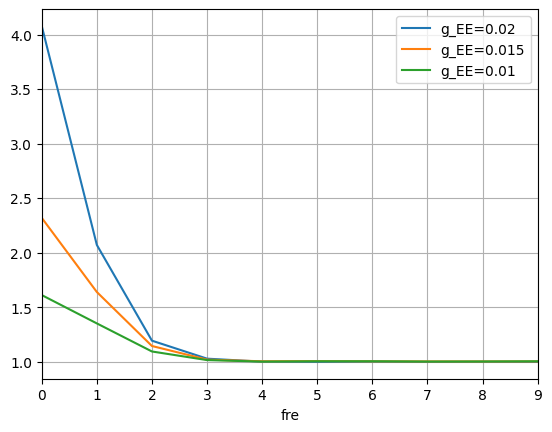

In [ ]:
frequency = np.arange(0,180)
fig,axs = subplots(1,1)  
# axs.plot(frequency,theory_model(0,0.004,0.012,25,frequency),'*-',label='theory mdoel')
axs.plot(np.asarray(delta_recordEE)/(np.asarray(delta_record1)),label='g_EE=0.02')
axs.plot(np.asarray(delta_recordEE1)/(np.asarray(delta_record1)),label='g_EE=0.015')
axs.plot(np.asarray(delta_recordEE2)/(np.asarray(delta_record1)),label='g_EE=0.01')
# axs.plot(np.asarray(delta_recordEIIE5)/(np.asarray(delta_record1)),label='spiking neuron model R_I=-50')
axs.grid()
axs.legend()
axs.set_xlim((0,9))
axs.set_xlabel('fre')

## EIIE connection

In [ ]:
delta_recordEIIE1,r_EIIE10,r_EIIE11,E_extEIIE10,E_extEIIE11,E_spike_EIIE1,I_spike_EIIE1,E_spiket0_EIIE1,E_spikei0_EIIE1,E_spiket1_EIIE1,E_spikei1_EIIE1,rates_I0_EIIE1,rates_I1_EIIE1 = frequency_test(C_in=800,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0.015*nS,g_EI=0.015*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordEIIE2,r_EIIE20,r_EIIE21,E_extEIIE20,E_extEIIE21,E_spike_EIIE2,I_spike_EIIE2,E_spiket0_EIIE2,E_spikei0_EIIE2,E_spiket1_EIIE2,E_spikei1_EIIE2,rates_I0_EIIE2,rates_I1_EIIE2 = frequency_test(C_in=800,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0.02*nS,g_EI=0.02*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordEIIE3,r_EIIE30,r_EIIE31,E_extEIIE30,E_extEIIE31,E_spike_EIIE3,I_spike_EIIE3,E_spiket0_EIIE3,E_spikei0_EIIE3,E_spiket1_EIIE3,E_spikei1_EIIE3,rates_I0_EIIE3,rates_I1_EIIE3 = frequency_test(C_in=800,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0*nS,g_IE=0.01*nS,g_EI=0.01*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)
# -20

Text(0.5, 0, 'fre')

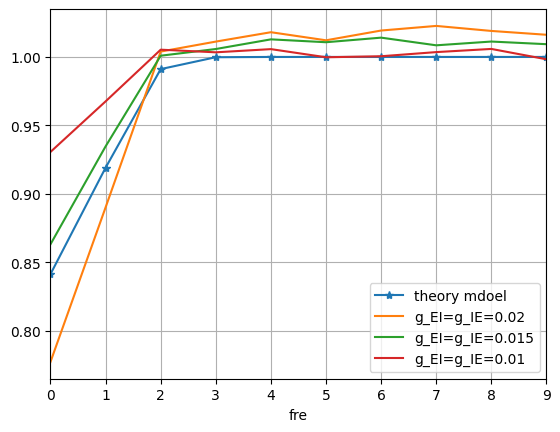

In [ ]:
frequency = np.arange(0,180)
fig,axs = subplots(1,1)  
axs.plot(frequency,theory_model(0,0.004,0.012,25,frequency),'*-',label='theory mdoel')
axs.plot(np.asarray(delta_recordEIIE2)/(np.asarray(delta_record1)),label='g_EI=g_IE=0.02')
axs.plot(np.asarray(delta_recordEIIE1)/(np.asarray(delta_record1)),label='g_EI=g_IE=0.015')
axs.plot(np.asarray(delta_recordEIIE3)/(np.asarray(delta_record1)),label='g_EI=g_IE=0.01')
axs.grid()
axs.legend()
axs.set_xlim((0,9))
axs.set_xlabel('fre')

Text(0.5, 0, 'fre')

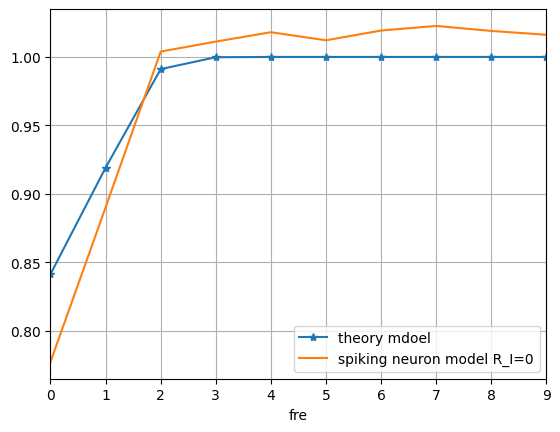

In [ ]:
frequency = np.arange(0,180)
fig,axs = subplots(1,1)  
axs.plot(frequency,theory_model(0,0.004,0.012,25,frequency),'*-',label='theory mdoel')
axs.plot(np.asarray(delta_recordEIIE2)/(np.asarray(delta_record1)),label='spiking neuron model R_I=0')
axs.grid()
axs.legend()
axs.set_xlim((0,9))
axs.set_xlabel('fre')

## All connection

In [ ]:
delta_recordall2,r_all20,r_all21,E_extall20,E_extall21,E_spike_all2,I_spike_all2,E_spiket0_all2,E_spikei0_all2,E_spiket1_all2,E_spikei1_all2,rates_I0_all2,rates_I1_all2 = frequency_test(C_in=600,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0.0125*nS,g_IE=0.06*nS,g_EI=0.0125*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordall,r_all0,r_all1,E_extall0,E_extall1,E_spike_all,I_spike_all,E_spiket0_all,E_spikei0_all,E_spiket1_all,E_spikei1_all,rates_I0_all,rates_I1_all = frequency_test(C_in=600,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0.02*nS,g_IE=0.03*nS,g_EI=0.04*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordall1,r_all1,r_all11,E_extall10,E_extall11,E_spike_all1,I_spike_all1,E_spiket0_all1,E_spikei0_all1,E_spiket1_all1,E_spikei1_all1,rates_I0_all1,rates_I1_all1 = frequency_test(C_in=800,amp=0.3,fre_range=10,amp_start=0,start_fre=0,g_EE=0.02*nS,g_IE=0.03*nS,g_EI=0.015*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordall3,r_all30,r_all31,E_extall30,E_extall31,E_spike_all3,I_spike_all3,E_spiket0_all3,E_spikei0_all3,E_spiket1_all3,E_spikei1_all3,rates_I0_all3,rates_I1_all3 = frequency_test(C_in=600,amp=0.3,fre_range=10,amp_start=0,g_EE=0.02*nS,g_IE=0.04*nS,g_EI=0.03*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

In [ ]:
delta_recordall4,r_all40,r_all41,E_extall40,E_extall41,E_spike_all4,I_spike_all4,E_spiket0_all4,E_spikei0_all4,E_spiket1_all4,E_spikei1_all4,rates_I0_all4,rates_I1_all4 = frequency_test(C_in=600,amp=0.3,fre_range=10,amp_start=0,g_EE=0.015*nS,g_IE=0.04*nS,g_EI=0.03*nS,g_II=0*nS,sigma_ori=25,N=600,C_bg=0,N_input=200)

Text(0.5, 0, 'fre')

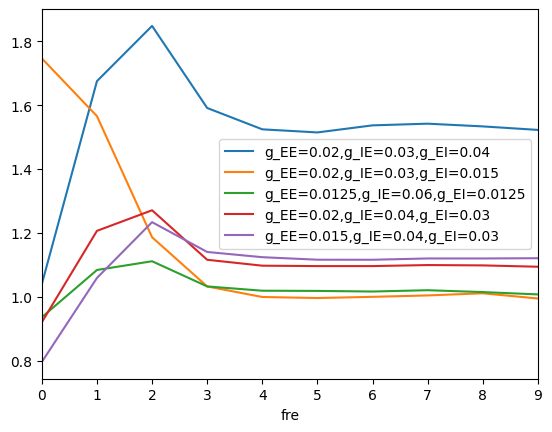

In [ ]:
frequency = np.arange(0,180)
fig,axs = subplots(1,1)  
axs.plot(np.asarray(delta_recordall)/(np.asarray(delta_record1)),label='g_EE=0.02,g_IE=0.03,g_EI=0.04')
axs.plot(np.asarray(delta_recordall1)/(np.asarray(delta_record1)),label='g_EE=0.02,g_IE=0.03,g_EI=0.015')
axs.plot(np.asarray(delta_recordall2)/(np.asarray(delta_record1)),label='g_EE=0.0125,g_IE=0.06,g_EI=0.0125')
axs.plot(np.asarray(delta_recordall3)/(np.asarray(delta_record1)),label='g_EE=0.02,g_IE=0.04,g_EI=0.03')
axs.plot(np.asarray(delta_recordall4)/(np.asarray(delta_record1)),label='g_EE=0.015,g_IE=0.04,g_EI=0.03')
# axs.grid()
axs.legend()
axs.set_xlim((0,9))
axs.set_xlabel('fre')

# Parameters consistent with the simplified model

In [ ]:
params = default_params()
params.g_EE = 0*nS
params.g_EI = 0.02*nS
params.g_IE = 0.02*nS
params.g_II = 0*nS
params.N_input = 200
params.center = 45
params.sigma_ori = 25
params.amp = 0
params.C_bg = 0
params.N = 600

In [ ]:
E_net_record_all = []
E_ext_record_all = []
E_exc_record_all = []
rates_E_record_all = []
rates_I_record_all = []
I_net_record_all = []
I_ext_record_all = []
I_exc_record_all = []
for C_total in range(750,950,20):
    rates_E,rates_I,E_ext,I_ext,E_net,I_net,E_exc,I_exc = result_monitor1(params, C_total=C_total, dtime=10*second)
    E_net_record_all.append(E_net)
    rates_E_record_all.append(rates_E)
    E_ext_record_all.append(E_ext)
    E_exc_record_all.append(E_exc)
    rates_I_record_all.append(rates_I)
    I_net_record_all.append(I_net)
    I_ext_record_all.append(I_ext)
    I_exc_record_all.append(I_exc)

WARNING    Group uses a dt of 5. us while TimedArray uses dt of 10. s (ratio: 1/1999999.9999999998) → time grids not aligned [brian2.input.timedarray]


In [ ]:
E_net_record_EIIE = []
E_ext_record_EIIE = []
rates_E_record_EIIE = []
rates_I_record_EIIE = []
I_net_record_EIIE = []
I_ext_record_EIIE = []
for C_total in range(750,850,50):
    rates_E,rates_I,E_ext,I_ext,E_net,I_net = result_monitor(params, C_total=C_total, dtime=10*second)
    E_net_record_EIIE.append(E_net)
    rates_E_record_EIIE.append(rates_E)
    E_ext_record_EIIE.append(E_ext)
    rates_I_record_EIIE.append(rates_I)
    I_net_record_EIIE.append(I_net)
    I_ext_record_EIIE.append(I_ext)

In [ ]:
params = default_params()
params.g_EE = 0.01*nS
params.g_EI = 0.02*nS
params.g_IE = 0.02*nS
params.g_II = 0*nS
params.N_input = 200
params.center = 45
params.sigma_ori = 25
params.amp = 0
params.C_bg = 0
params.N = 600
# params.tau_m = 30*ms

In [ ]:
E_net_record_all1 = []
E_ext_record_all1 = []
E_exc_record_all1 = []
rates_E_record_all1 = []
rates_I_record_all1 = []
I_net_record_all1 = []
I_ext_record_all1 = []
I_exc_record_all1 = []
for C_total in range(750,950,10):
    rates_E,rates_I,E_ext,I_ext,E_net,I_net,E_exc,I_exc = result_monitor1(params, C_total=C_total, dtime=10*second)
    E_net_record_all1.append(E_net)
    rates_E_record_all1.append(rates_E)
    E_ext_record_all1.append(E_ext)
    E_exc_record_all1.append(E_exc)
    rates_I_record_all1.append(rates_I)
    I_net_record_all1.append(I_net)
    I_ext_record_all1.append(I_ext)
    I_exc_record_all1.append(I_exc)

In [ ]:
params = default_params()
params.g_EE = 0.01*nS
params.g_EI = 0.02*nS
params.g_IE = 0.02*nS
params.g_II = 0*nS
params.N_input = 200
params.center = 45
params.sigma_ori = 25
params.amp = 0
params.C_bg = 0
params.N = 600
params.fre = 10
params.amp = 0.3

In [ ]:
E_net_record_all1_fre10 = []
E_ext_record_all1_fre10 = []
E_exc_record_all1_fre10 = []
rates_E_record_all1_fre10 = []
rates_I_record_all1_fre10 = []
I_net_record_all1_fre10 = []
I_ext_record_all1_fre10 = []
I_exc_record_all1_fre10 = []
for C_total in range(0,1800,20):
    rates_E,rates_I,E_ext,I_ext,E_net,I_net,E_exc,I_exc = result_monitor1(params, C_total=C_total, dtime=10*second)
    E_net_record_all1_fre10.append(E_net)
    rates_E_record_all1_fre10.append(rates_E)
    E_ext_record_all1_fre10.append(E_ext)
    E_exc_record_all1_fre10.append(E_exc)
    rates_I_record_all1_fre10.append(rates_I)
    I_net_record_all1_fre10.append(I_net)
    I_ext_record_all1_fre10.append(I_ext)
    I_exc_record_all1_fre10.append(I_exc)

In [ ]:
mean(mean(np.asarray(E_net_record_all1/pamp),2),1),mean(np.asarray(rates_E_record_all1),2)[:,0]

(array([379.17944355, 382.29055621, 385.87892089, 389.05872145,
        392.17665338, 395.32249403, 398.81531761, 402.1215537 ,
        405.48038717, 408.56795759, 411.93382411, 415.1889071 ,
        418.52508465, 422.02909299, 425.39256364, 428.36016791,
        431.73062529, 435.00137466, 438.18386881, 441.37715729]),
 array([229.97216667, 233.68333333, 237.33916667, 241.07833333,
        244.71183333, 248.38633333, 252.136     , 255.785     ,
        259.464     , 263.19033333, 266.83833333, 270.53633333,
        274.23633333, 277.90733333, 281.606     , 285.30433333,
        288.94166667, 292.63133333, 296.35783333, 300.04233333]))

In [ ]:
np.asarray(rates_E_record_all1_fre10/pamp).shape

(90, 1, 600)

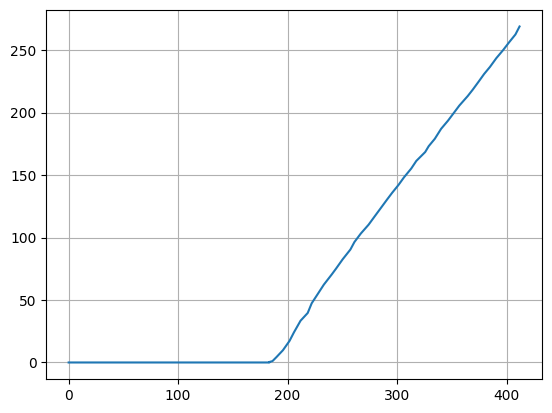

In [ ]:
index = 150
plot(mean(np.asarray(E_net_record_all1_fre10/pamp),2)[:,index],np.asarray(rates_E_record_all1_fre10)[:,0,index])
grid()
# xlim((800,1000))
# ylim((600,1000))

Text(0, 0.5, 'firing rate')

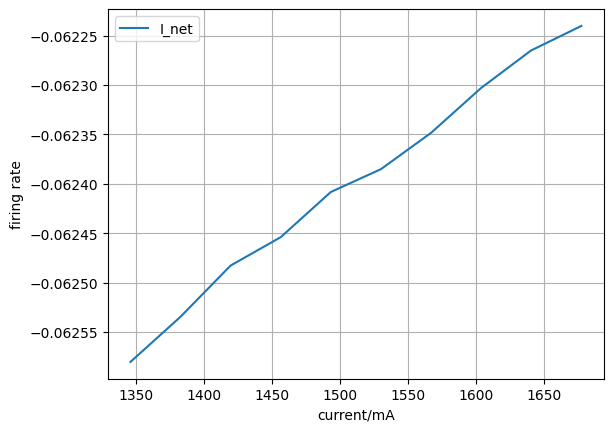

In [ ]:
k_EI = []
k_IE = []
k_EE = []
for i in range(10):
    k_EE.append((mean(np.asarray(rates_E_record_all)[i,0,:])-(1.12*mean(mean(np.asarray(E_ext_record_all/pamp)+(np.asarray(E_net_record_all/pamp)-np.asarray(E_exc_record_all/pamp)-np.asarray(E_ext_record_all/pamp)),1),1)[i]-196))/mean(np.asarray(rates_E_record_all)[i,0,:])/31.33/2)
    k_EI.append(-(mean(np.asarray(rates_E_record_all)[i,0,:])-(1.12*mean(mean(np.asarray(E_ext_record_all/pamp)+np.asarray(E_exc_record_all/pamp),1),1)[i]-196))/mean(np.asarray(rates_I_record_all)[i,0,:])/31.333/2)
    k_IE.append((mean(np.asarray(rates_I_record_all)[i,0,:])-(1.12*mean(mean(np.asarray(I_ext_record_all/pamp),1),1)[i]-196))/mean(np.asarray(rates_E_record_all)[i,0,:])/31.333/2)
# plot(mean(mean(np.asarray(I_net_record_EIIE/pamp),1),1),k_IE,label='I_net')
plot(mean(mean(np.asarray(I_net_record_all/pamp),1),1),k_EE,label='I_net')
grid()
legend()
xlabel('current/mA')
ylabel('firing rate')

Text(0, 0.5, 'firing rate')

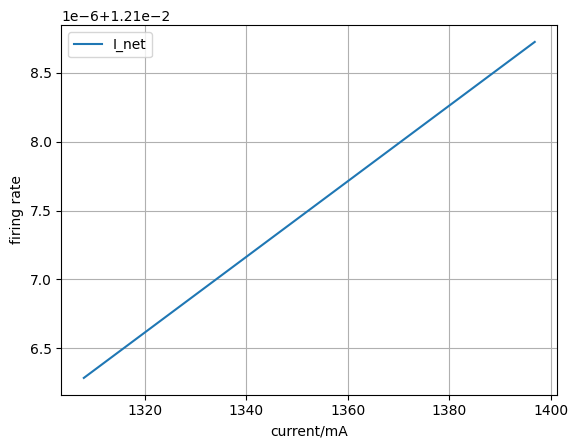

In [ ]:
k_EI = []
k_IE = []
for i in range(2):
    k_EI.append(-(mean(np.asarray(rates_E_record_EIIE)[i,0,:])-(1.12*mean(mean(np.asarray(E_ext_record_EIIE/pamp),1),1)[i]-196))/mean(np.asarray(rates_I_record_EIIE)[i,0,:])/31.333/2)
    k_IE.append((mean(np.asarray(rates_I_record_EIIE)[i,0,:])-(1.12*mean(mean(np.asarray(I_ext_record_EIIE/pamp),1),1)[i]-196))/mean(np.asarray(rates_E_record_EIIE)[i,0,:])/31.333/2)
plot(mean(mean(np.asarray(I_net_record_EIIE/pamp),1),1),k_EI,label='I_net')
grid()
legend()
xlabel('current/mA')
ylabel('firing rate')

In [ ]:
k_EI,k_IE

([0.012106286047474284, 0.012108723165970819],
 [0.011435725066756353, 0.011376749618429629])

# Compare with the simplified model

In [ ]:
index = 0
no_mean = [mean(E_net11[index]/pA),mean(E_net21[index]/pA),mean(E_net31[index]/pA)]
no_var = [mean(var(E_net11[index]/pA,1)),mean(var(E_net21[index]/pA,1)),mean(var(E_net31[index]/pA,1))]
EE_mean = [mean(E_net_EE1[index]/pA),mean(E_net_EE11[index]/pA),mean(E_net_EE21[index]/pA)]
EE_var = [mean(var(E_net_EE1[index]/pA,1)),mean(var(E_net_EE11[index]/pA,1)),mean(var(E_net_EE21[index]/pA,1))]
EIIE_mean = [mean(I_spike_EIIE1[index]/pA),mean(I_spike_EIIE2[index]/pA),mean(I_spike_EIIE4[index]/pA)]
EIIE_var = [mean(var(I_spike_EIIE1[index]/pA,1)),mean(var(I_spike_EIIE2[index]/pA,1)),mean(var(I_spike_EIIE4[index]/pA,1))]

In [ ]:
for index in range(1,10):
    no_mean.extend([mean(E_net11[index]/pA),mean(E_net21[index]/pA),mean(E_net31[index]/pA)])
    no_var.extend([mean(var(E_net11[index]/pA,1)),mean(var(E_net21[index]/pA,1)),mean(var(E_net31[index]/pA,1))])
    EE_mean.extend([mean(E_net_EE1[index]/pA),mean(E_net_EE11[index]/pA),mean(E_net_EE21[index]/pA)])
    EE_var.extend([mean(var(E_net_EE1[index]/pA,1)),mean(var(E_net_EE11[index]/pA,1)),mean(var(E_net_EE21[index]/pA,1))])
    EIIE_mean.extend([mean(I_spike_EIIE1[index]/pA),mean(I_spike_EIIE2[index]/pA),mean(I_spike_EIIE4[index]/pA)])
    EIIE_var.extend([mean(var(I_spike_EIIE1[index]/pA,1)),mean(var(I_spike_EIIE2[index]/pA,1)),mean(var(I_spike_EIIE4[index]/pA,1))])

Text(0, 0.5, 'net input varience')

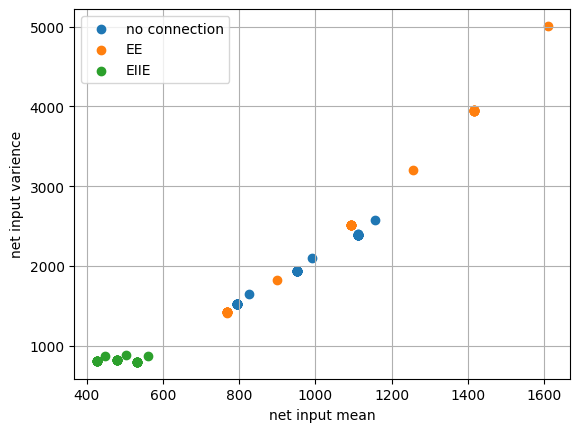

In [ ]:
scatter(no_mean,no_var,label='no connection')
scatter(EE_mean,EE_var,label='EE')
scatter(EIIE_mean,EIIE_var,label= 'EIIE')
grid()
legend()
xlabel('net input mean')
ylabel('net input varience')

In [ ]:
def theory_model(g_EE,g_EI,g_IE,sigma,frequency):
    return 1/(1-g_EE*np.sqrt(2*np.pi)*sigma*np.exp(-2*np.pi**2*sigma**2*(frequency/180)**2)+2*np.pi*g_EI*g_IE*sigma**2*np.exp(-4*np.pi**2*sigma**2*(frequency/180)**2))

In [ ]:
fontsize = 20
plt.rc('font', size=fontsize)  # set global font size for the title
plt.rc('axes', titlesize=fontsize)  # Set globle font size for axis titles 
plt.rc('axes', labelsize=fontsize)  # Set globle font size for axis labels
plt.rc('xtick', labelsize=fontsize)  # Set globle font size for X-axis tick labels
plt.rc('ytick', labelsize=fontsize)  # Set globle font size for Y-axis tick labels
plt.rc('legend', fontsize=fontsize)  # Set globle font size for legend labels

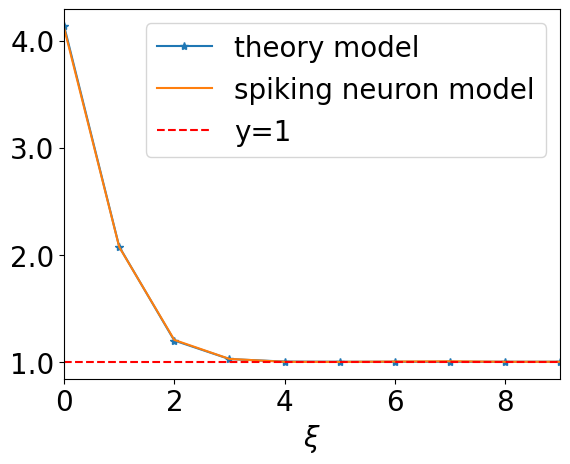

In [ ]:
from matplotlib.ticker import FormatStrFormatter
frequency = np.arange(0,180)
fig,axs = subplots(1,1) 
# plot(frequency,theory_model(0.0121,0,0,25,frequency),'-*',label='theory model')
axs.plot(frequency,theory_model(0.0121,0,0,25,frequency),'-*',label='theory model')
axs.plot(np.asarray(delta_recordEE)/np.asarray(delta_record1),label='spiking neuron model')
axs.axhline(y=1, color='r', linestyle='--', label='y=1')
axs.set_xlim((0,9))
# grid()
axs.legend()
axs.set_xlabel(r'$\xi$')
axs.yaxis.set_major_locator(MultipleLocator(1.0))  # Set major tick interval to 0.2
axs.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
fig.savefig("EE.pdf", format="pdf")

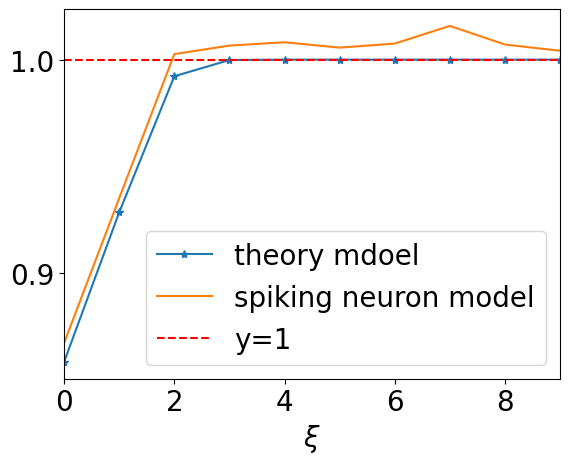

In [ ]:
frequency = np.arange(0,180)
fig,axs = subplots(1,1)  
axs.plot(frequency,theory_model(0,0.00472,0.0089,25,frequency),'*-',label='theory mdoel')
axs.plot(np.asarray(delta_recordEIIE1)/(np.asarray(delta_record1)),label='spiking neuron model')
axs.axhline(y=1, color='r', linestyle='--', label='y=1')
# axs.grid()
axs.legend()
axs.set_xlim((0,9))
axs.set_xlabel(r'$\xi$')
from matplotlib.ticker import MultipleLocator
axs.yaxis.set_major_locator(MultipleLocator(0.1))  # Set major tick interval to 0.2
fig.savefig("EIIE.pdf", format="pdf")


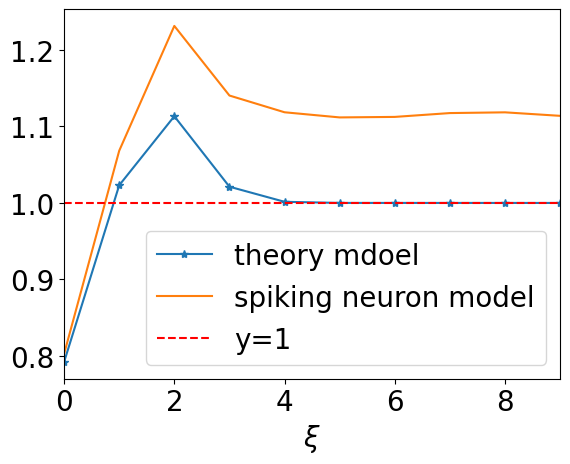

In [ ]:
frequency = np.arange(0,180)
fig,axs = subplots(1,1)  
axs.plot(frequency,theory_model(0.010693,0.013612,0.01744,25,frequency),'*-',label='theory mdoel')
axs.plot(np.asarray(delta_recordall4)/(np.asarray(delta_record1)),label='spiking neuron model')
axs.axhline(y=1, color='r', linestyle='--', label='y=1')
# axs.grid()
axs.legend()
axs.set_xlim((0,9))
axs.set_xlabel(r'$\xi$')
fig.savefig("all.pdf", format="pdf")

# Plot Results

## rates plot

In [ ]:
theta = np.arange(600)/600*180

WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_2109/19933929.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[i,j].plot(theta, r11[5*i+j]-r10[0], '.k',color='r',label = 'no connection')
 [py.warnings]
WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_2109/19933929.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[i,j].plot(theta, 1.2*(r_EE01[5*i+j]-r_EE00[0]), '.k',color='g',label = 'EE')
 [py.warnings]
WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_2109/19933929.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[i,j].plot(theta, r_EIIE11[5*i+j]-r_EIIE10[0], '.k',color='

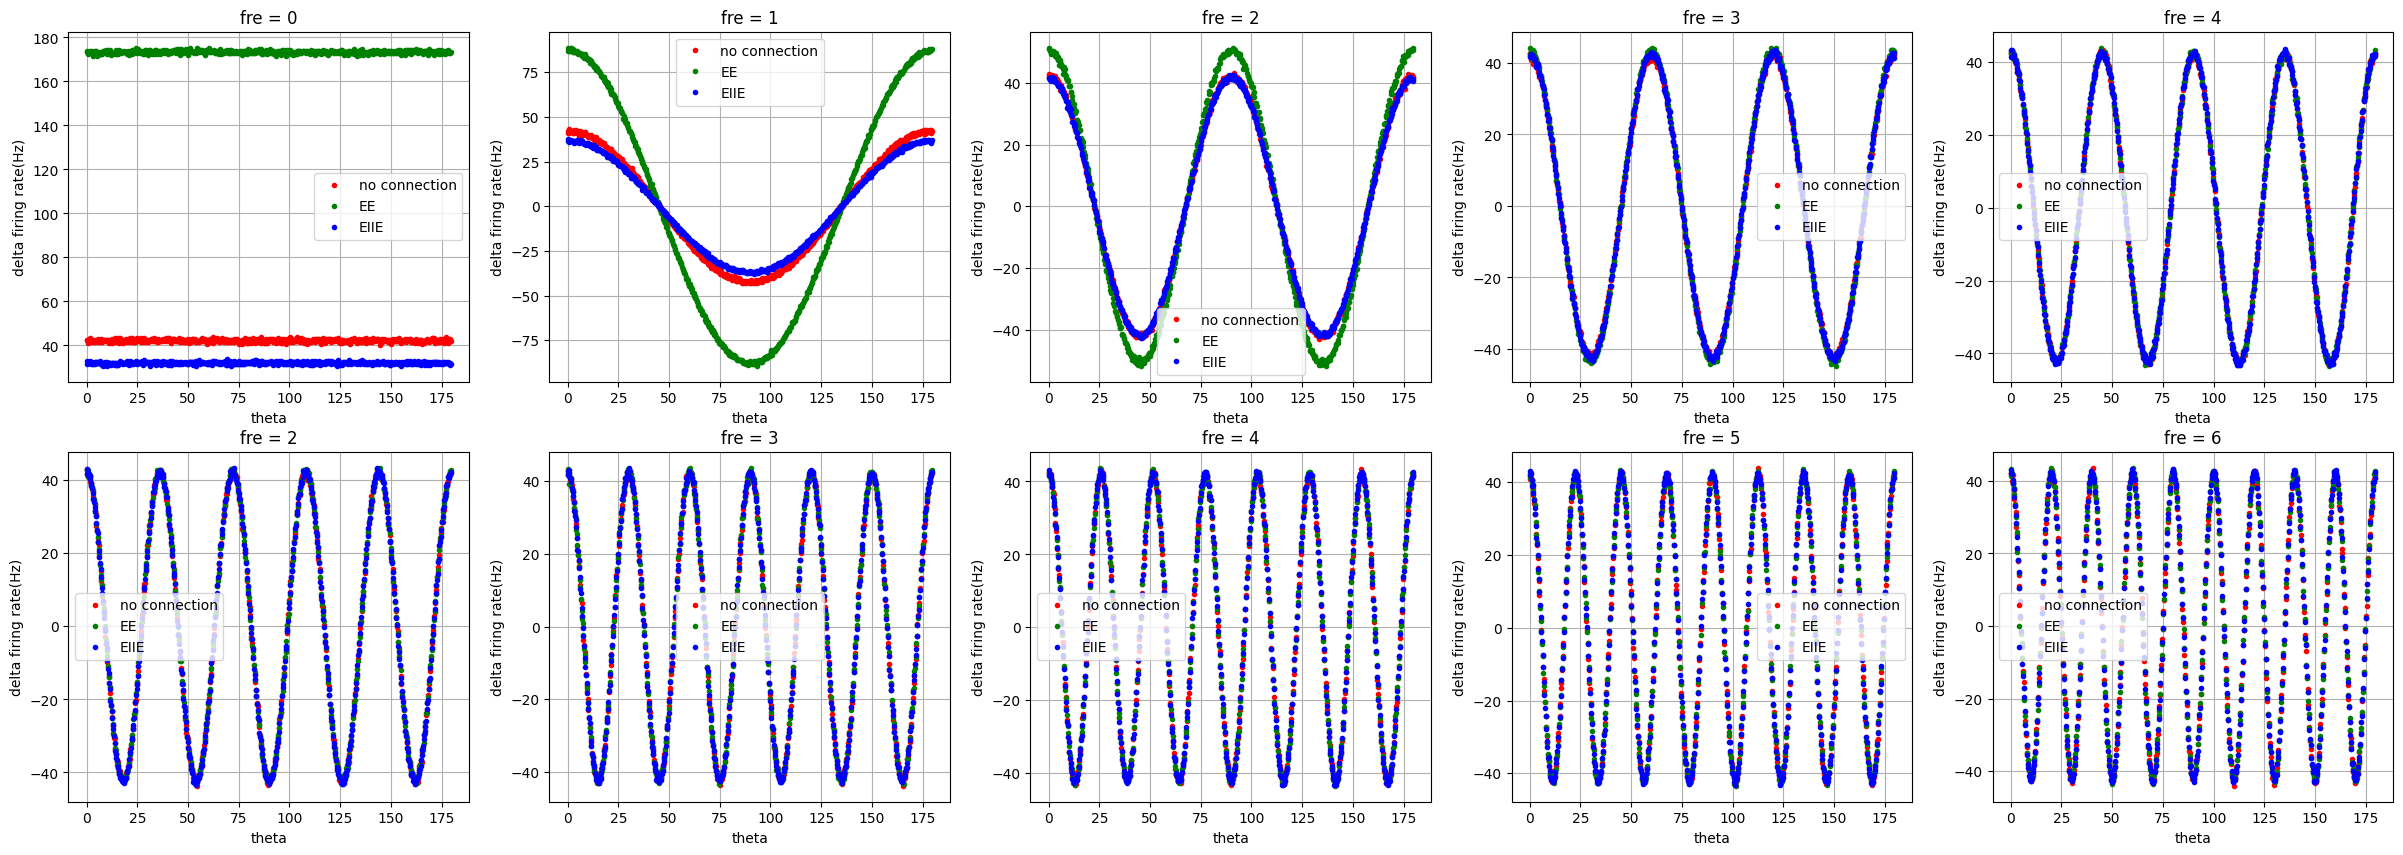

In [ ]:
fig,axs = subplots(2,5,figsize = (30,10))
for i in range(2):
    for j in range(5):
        axs[i,j].plot(theta, r11[5*i+j]-r10[0], '.k',color='r',label = 'no connection')
        axs[i,j].plot(theta, 1.2*(r_EE01[5*i+j]-r_EE00[0]), '.k',color='g',label = 'EE')
        axs[i,j].plot(theta, r_EIIE11[5*i+j]-r_EIIE10[0], '.k',color='b',label = 'EIIE')
        # axs[i,j].plot(params.theta[:params.N], r11[2*i+j]-rates_I_record00[2*i+j], '.k',marker='*',color='g',label = 'E')
        axs[i,j].legend()
        axs[i,j].grid()
        axs[i,j].set_xlabel('theta')
        axs[i,j].set_ylabel('delta firing rate(Hz)')
        axs[i,j].set_title("fre = "+str((2*i+j)))

WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_805/1216444330.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[i,j].plot(theta, r_all41[3*i+j]-r_all40[0], '.k',color='b',label = 'All connections')
 [py.warnings]
WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_805/1216444330.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[i,j].plot(theta, r11[3*i+j]-r10[0], '.k',color='r',label = 'No connections')
 [py.warnings]


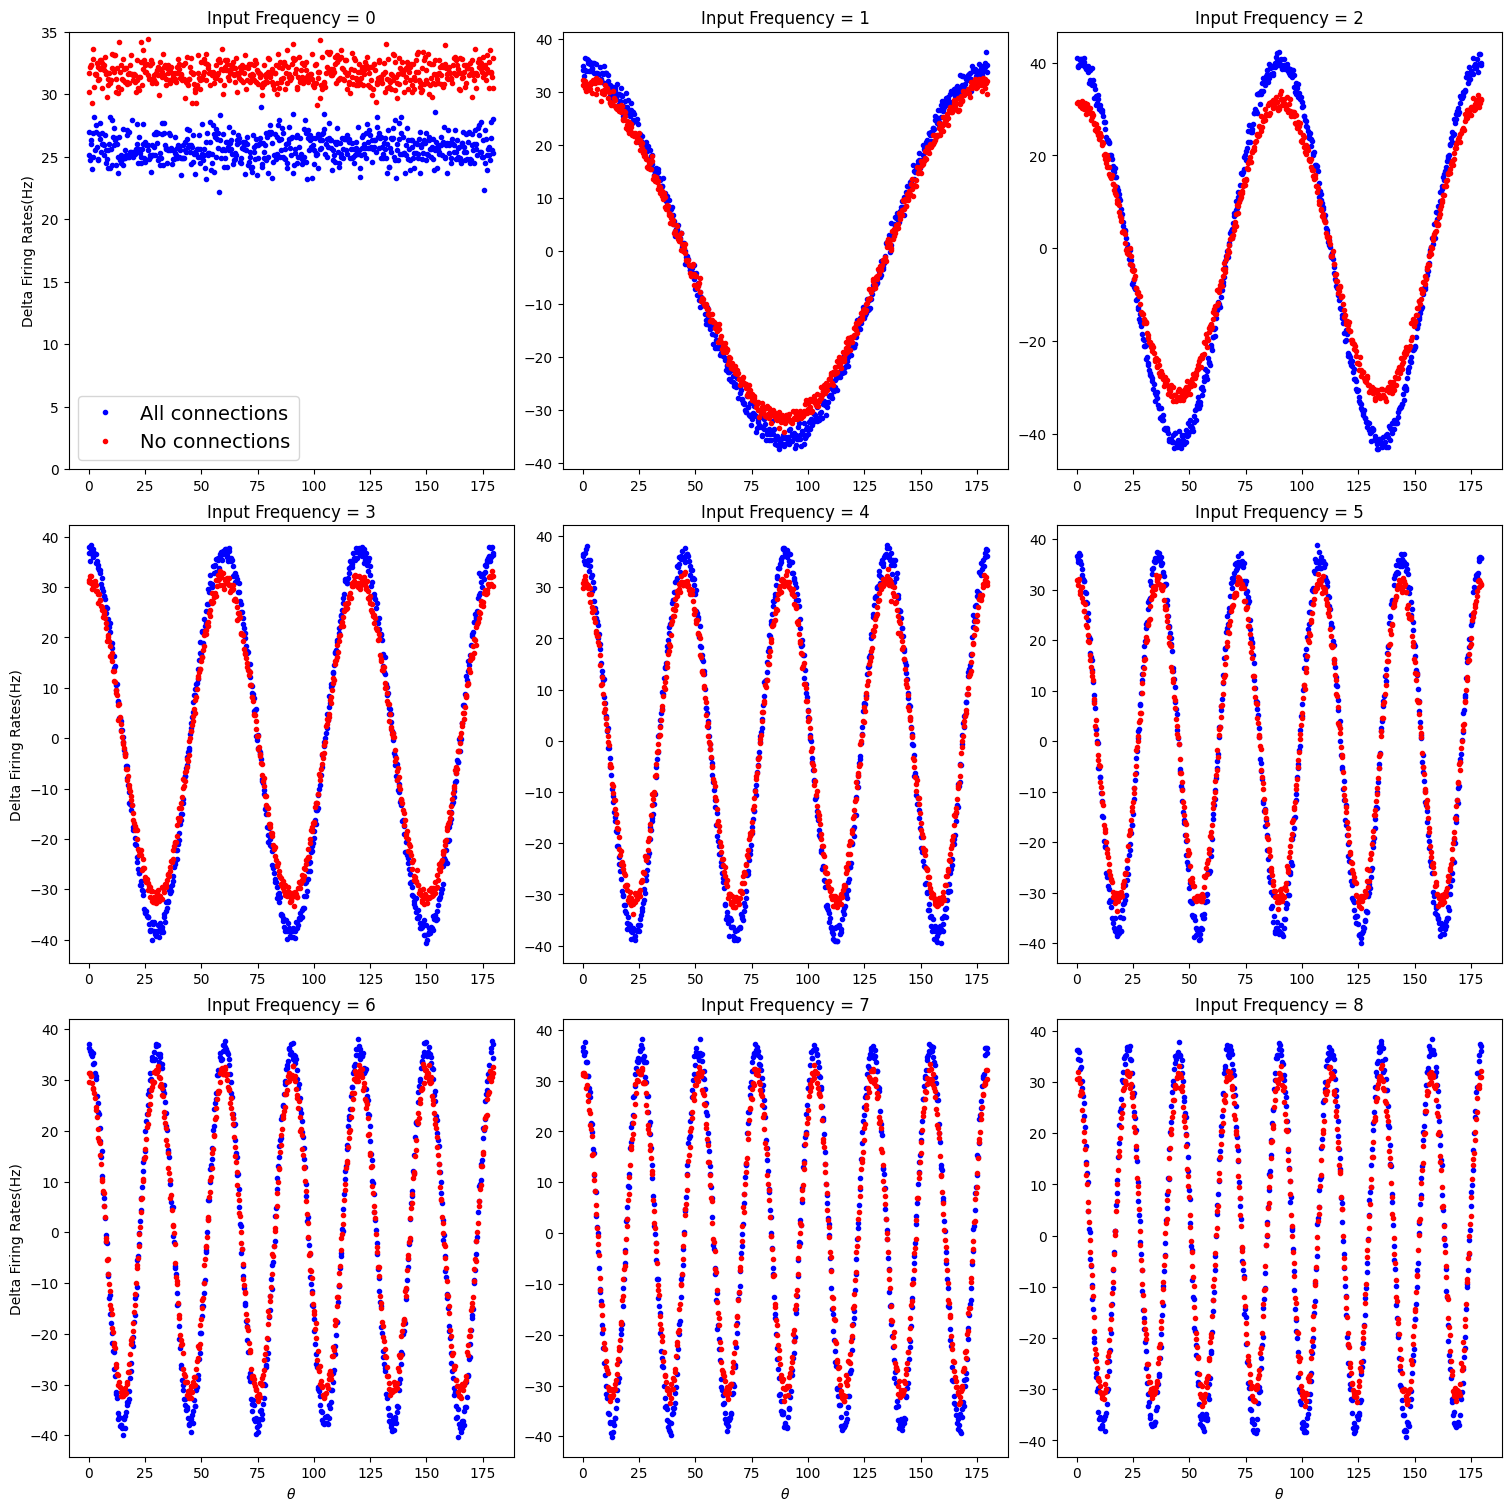

In [ ]:
fig,axs = subplots(3,3,figsize = (15,15),constrained_layout=True)
for i in range(3):
    for j in range(3):
        axs[i,j].plot(theta, r_all41[3*i+j]-r_all40[0], '.k',color='b',label = 'All connections')
        axs[i,j].plot(theta, r11[3*i+j]-r10[0], '.k',color='r',label = 'No connections')
        if i == 0 and j == 0:
            axs[i,j].set_ylim((0,35))
        # axs[i,j].plot(params.theta[:params.N], r11[2*i+j]-rates_I_record00[2*i+j], '.k',marker='*',color='g',label = 'E')
        # axs[i,j].grid()
        if i == 2:
            axs[i,j].set_xlabel(r'$\theta$')
        if j == 0:
            axs[i,j].set_ylabel('Delta Firing Rates(Hz)')
        axs[i,j].set_title(r"Input Frequency = "+str((3*i+j)))
axs[0,0].legend(fontsize=14)

WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_805/1751104292.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[j].plot(theta, r_all41[3*i+j]-r_all40[0], '.k',color='b',label = 'All connections')
 [py.warnings]
WARNING    /var/folders/nm/bg53r4ms3b108956v74gzdqm0000gn/T/ipykernel_805/1751104292.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  axs[j].plot(theta, r11[3*i+j]-r10[0], '.k',color='r',label = 'No connections')
 [py.warnings]


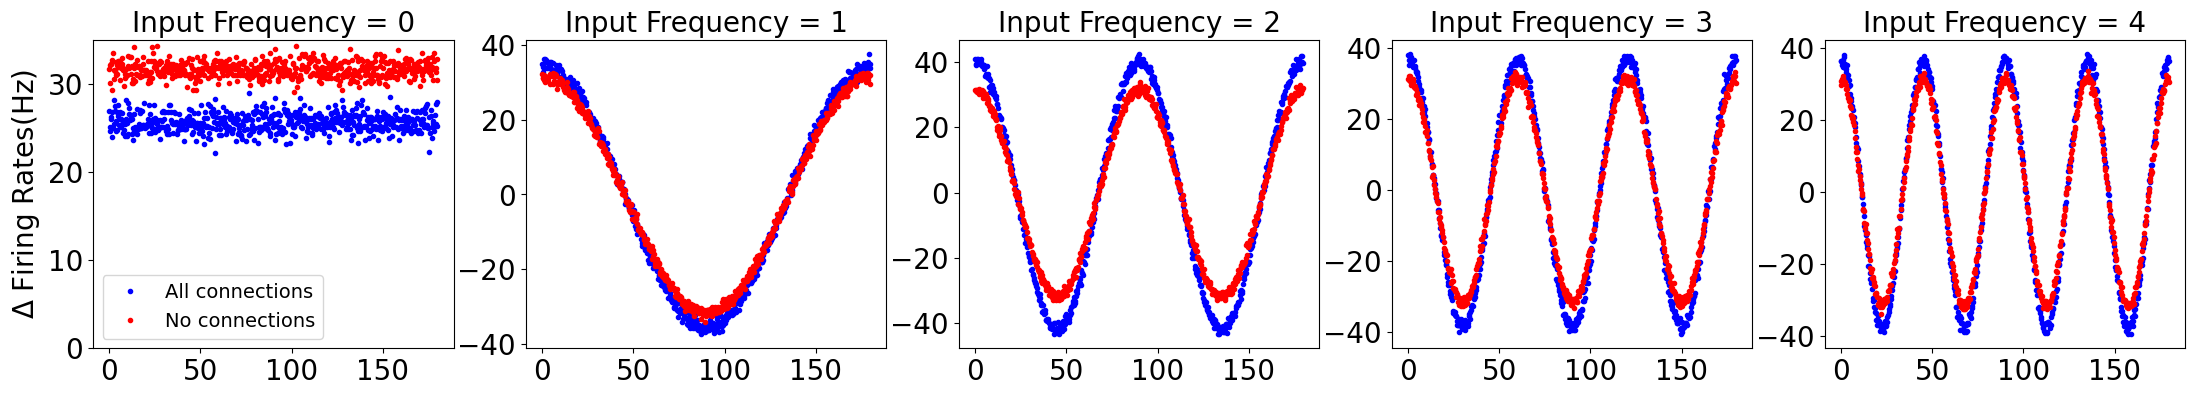

In [ ]:
plt.rcParams['font.size'] = 18
fig,axs = subplots(1,5,figsize = (27,4))
for i in range(1):
    for j in range(5):
        axs[j].plot(theta, r_all41[3*i+j]-r_all40[0], '.k',color='b',label = 'All connections')
        axs[j].plot(theta, r11[3*i+j]-r10[0], '.k',color='r',label = 'No connections')
        if i == 0 and j == 0:
            axs[j].set_ylim((0,35))
        # axs[i,j].plot(params.theta[:params.N], r11[2*i+j]-rates_I_record00[2*i+j], '.k',marker='*',color='g',label = 'E')
        # axs[i,j].grid()
        if i == 2:
            axs[j].set_xlabel(r'$\theta$')
        if j == 0:
            axs[j].set_ylabel('$\Delta$ Firing Rates(Hz)')
        axs[j].set_title(r"Input Frequency = "+str((3*i+j)))
axs[0].legend(fontsize=14)
fig.savefig("ratesplot.pdf", format="pdf")

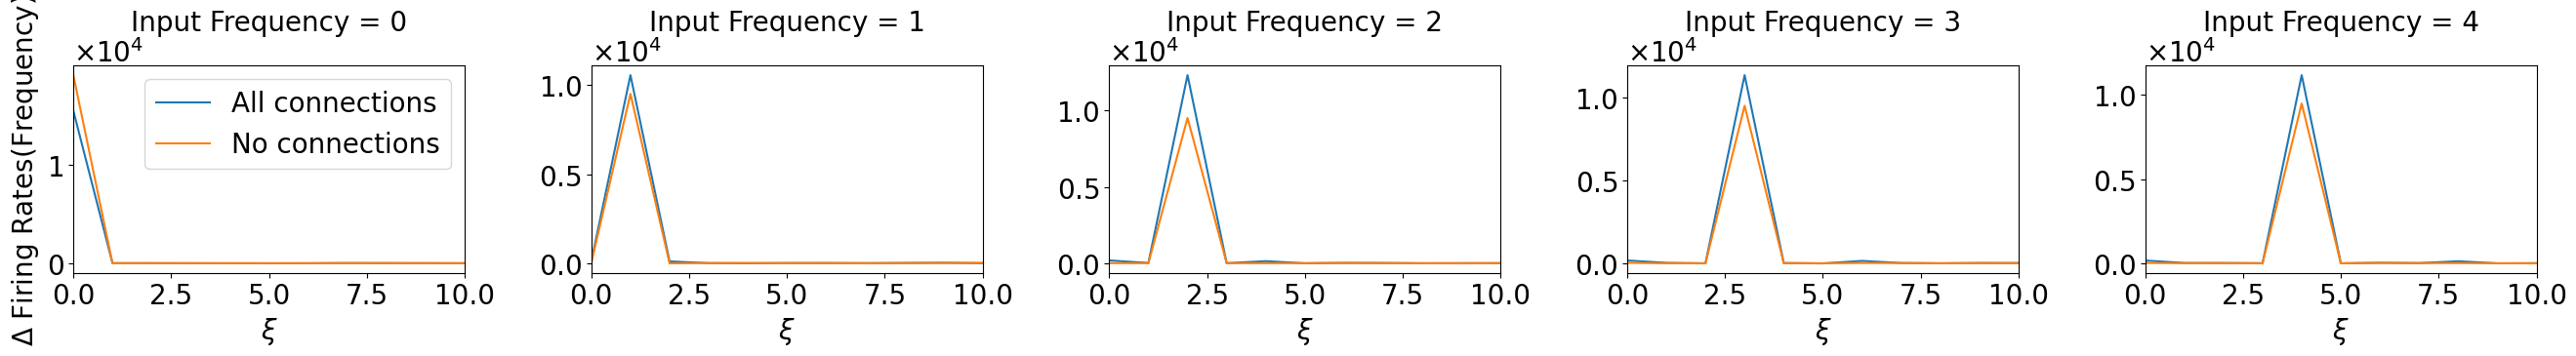

In [ ]:
plt.rcParams['font.size'] = 18  # Set global font size
from matplotlib.ticker import ScalarFormatter

fig,axs = subplots(1,5,figsize = (27,4))
for i in range(1):
    for j in range(5):
        fft_y=np.fft.fft((np.asarray(r_all41)-np.asarray(r_all40))[3*i+j])
        fft_y0 = np.fft.fft((np.asarray(r11)-np.asarray(r10))[3*i+j])
        x = np.arange(600)           
        abs_y=np.abs(fft_y) 
        abs_y0=np.abs(fft_y0)      
        axs[j].plot(x,abs_y,label='All connections')
        axs[j].plot(x,abs_y0,label='No connections')
        axs[j].set_xlim((0,10))
        # axs[i,j].grid()
        if i==0:
            axs[j].set_xlabel(r'$\xi$')
        if j==0:
            axs[j].set_ylabel('$\Delta$ Firing Rates(Frequency)')
        axs[j].set_title(r"Input Frequency = "+str((3*i+j)))

        axs[j].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))  # Use scientific notation
        axs[j].ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))  # Set to scientific notation
axs[0].legend()
fig.tight_layout()
fig.savefig("frequencyplot.pdf", format="pdf")

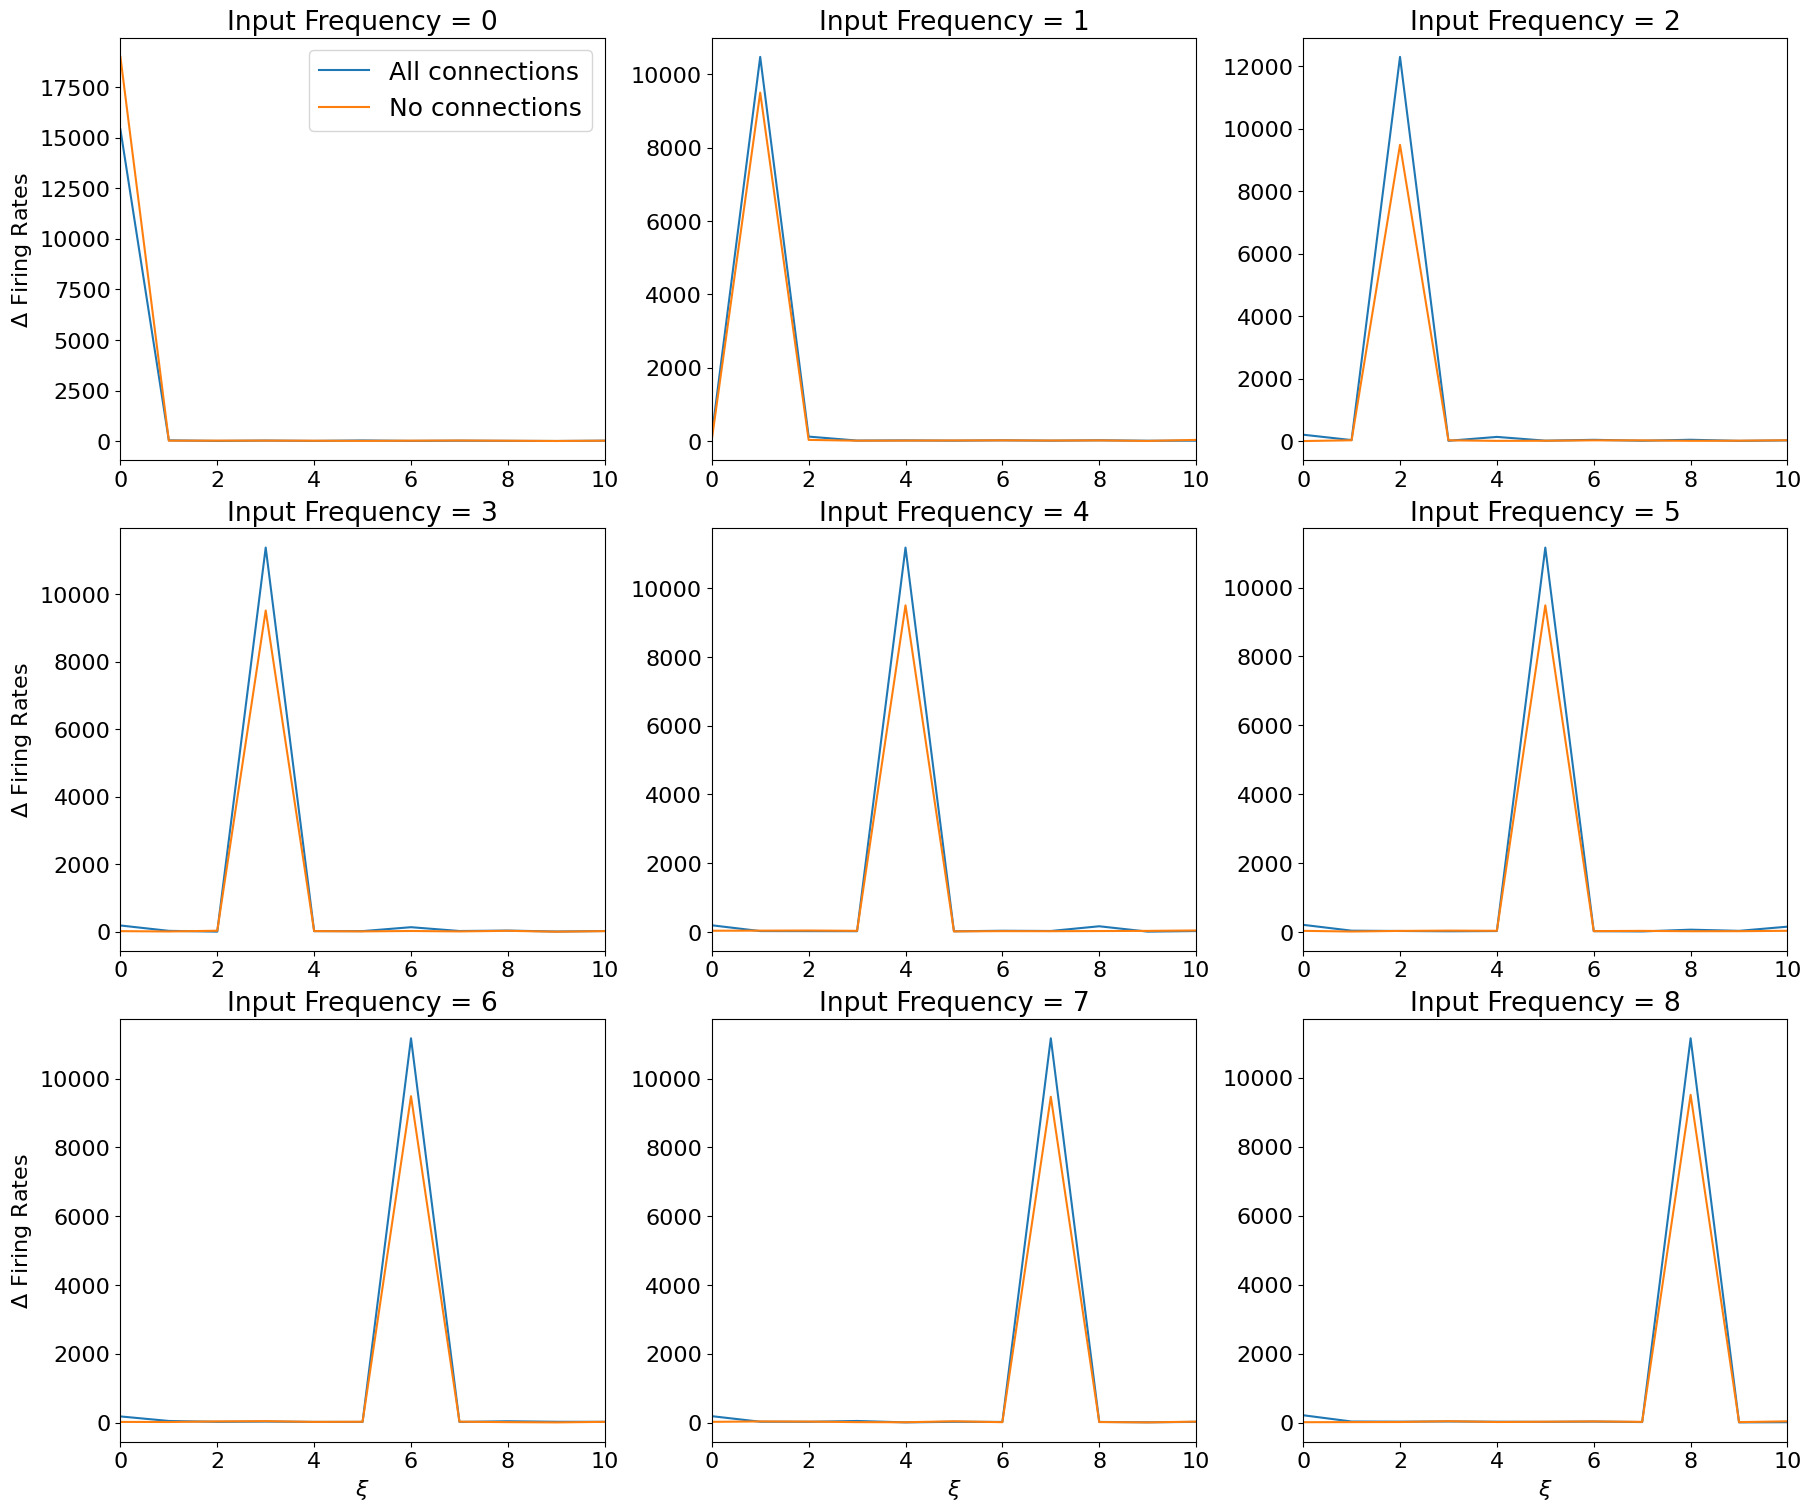

In [ ]:
plt.rcParams['font.size'] = 16  # Set global font size
fig,axs = subplots(3,3,figsize = (18,15),constrained_layout=True)
for i in range(3):
    for j in range(3):
        fft_y=np.fft.fft((np.asarray(r_all41)-np.asarray(r_all40))[3*i+j])
        fft_y0 = np.fft.fft((np.asarray(r11)-np.asarray(r10))[3*i+j])
        x = np.arange(600)           
        abs_y=np.abs(fft_y) 
        abs_y0=np.abs(fft_y0)      
        axs[i,j].plot(x,abs_y,label='All connections')
        axs[i,j].plot(x,abs_y0,label='No connections')
        axs[i,j].set_xlim((0,10))
        # axs[i,j].grid()
        if i==2:
            axs[i,j].set_xlabel(r'$\xi$')
        if j==0:
            axs[i,j].set_ylabel('$\Delta$ Firing Rates')
        axs[i,j].set_title(r"Input Frequency = "+str((3*i+j)))
axs[0,0].legend()